In [318]:
%load_ext autoreload
%autoreload 2

import sys
import os
import pandas as pd
from string import Template
PATH_TO_PYSEIR_ROOT = '/Users/xzhang/Documents/covid/county_covid_seir_models/'
sys.path.append(PATH_TO_PYSEIR_ROOT)

import numpy as np
from pyseir.models.seir_model_age import SEIRModelAge
from pyseir.models.seir_model import SEIRModel
from pyseir.models.suppression_policies import generate_triggered_suppression_model
import matplotlib.pyplot as plt
from pyseir.models.age_structure import get_age_distribution_and_contact_matrix
from pyseir import load_data

n_days = 360
t_list = np.linspace(0, n_days, n_days)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [319]:
THIS_FILE_PATH = os.path.dirname(os.path.realpath('__file__'))

In [320]:
config = dict(fips = '06075',
              contact_matrices_r_script_path = THIS_FILE_PATH + '/../pyseir/models/contact_matrices.r',
              r_substitution = dict(survey_source='polymod',
                                    country = 'United Kingdom',
                                    num_sample = 10,
                                    weight_by_dayofweek='TRUE',
                                    matrices='$matrices',
                                    matrix='$matrix'))

In [321]:
age_bin_edges, age_group_sizes, contact_matrix = get_age_distribution_and_contact_matrix(config)

R[write to console]: Using POLYMOD social contact data. To cite this in a publication, use the 'cite' function



In [322]:
# some fabricated data ...
hospitalization_rate_general = np.array([0.01, 0.01, 0.025, 0.02, 0.02, 0.03, 0.04, 0.05, 
                                         0.1, 0.2, 0.2, 0.2, 0.3, 0.4, 0.5, 0.6])
hospitalization_rate_icu = np.array([0.001, 0.002, 0.002, 0.002, 0.003, 0.003, 0.004, 0.004, 0.005, 0.005, 
                                     0.01, 0.02, 0.02, 0.03, 0.05, 0.1])
mortality_rate = np.array([0.001, 0.001, 0.0015, 0.0015, 0.0015, 0.002, 0.003, 0.003, 
                           0.005, 0.006, 0.007, 0.01, 0.02, 0.03, 0.04, 0.05])

In [334]:
R0 = 3.5

#### When there is NO age structure

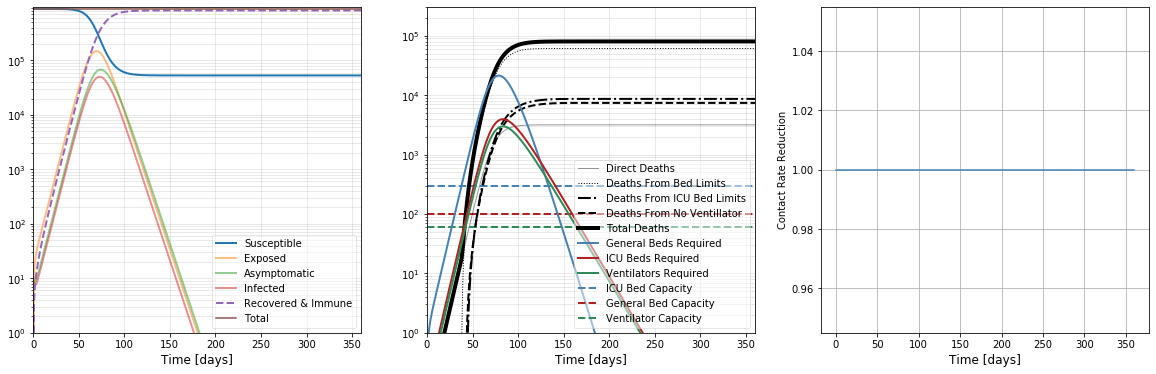

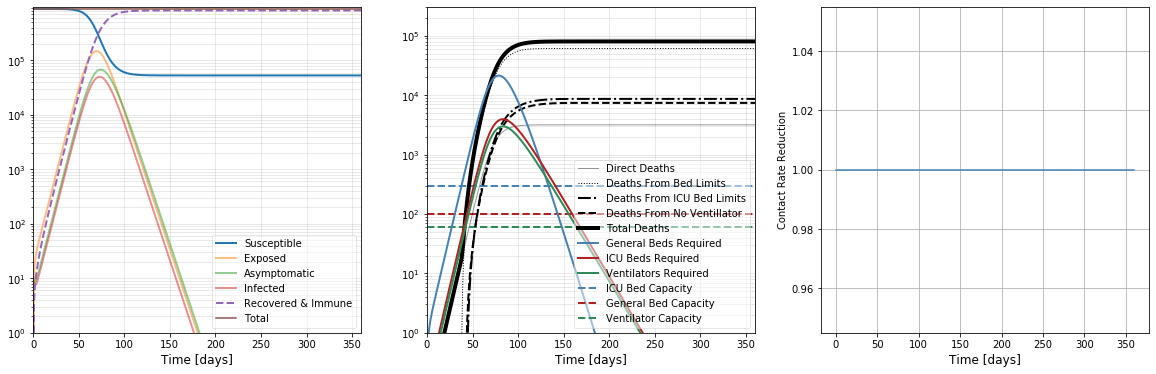

In [335]:
suppression_policy = generate_triggered_suppression_model(t_list=t_list, lockdown_days=0, open_days=0, reduction=1)
model = SEIRModel(
    N=age_group_size.sum(),
    A_initial=10,
    I_initial=10, 
    t_list=t_list,
    R0=R0,
    hospitalization_rate_general=(hospitalization_rate_general*age_group_size).sum() / age_group_size.sum(),
    hospitalization_rate_icu=(hospitalization_rate_icu*age_group_size).sum() / age_group_size.sum(),
    mortality_rate=(mortality_rate*age_group_size).sum() / age_group_size.sum(),
    suppression_policy=suppression_policy)

model.run()
model.plot_results()

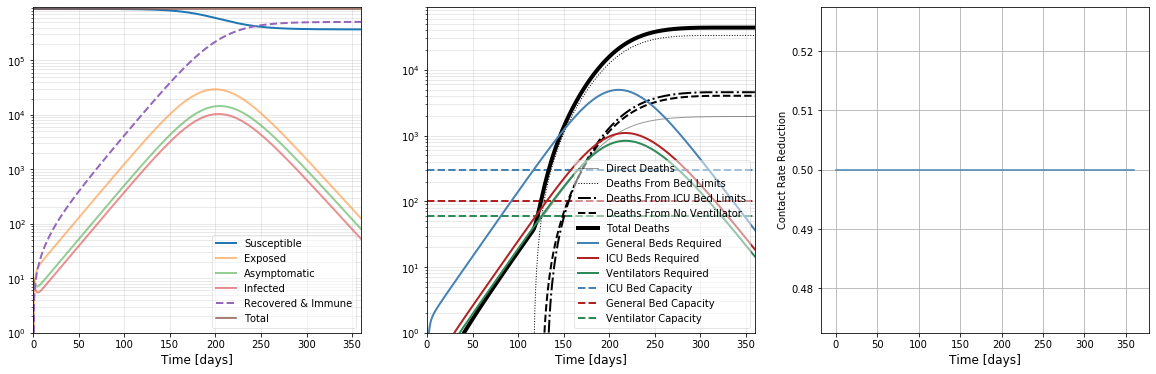

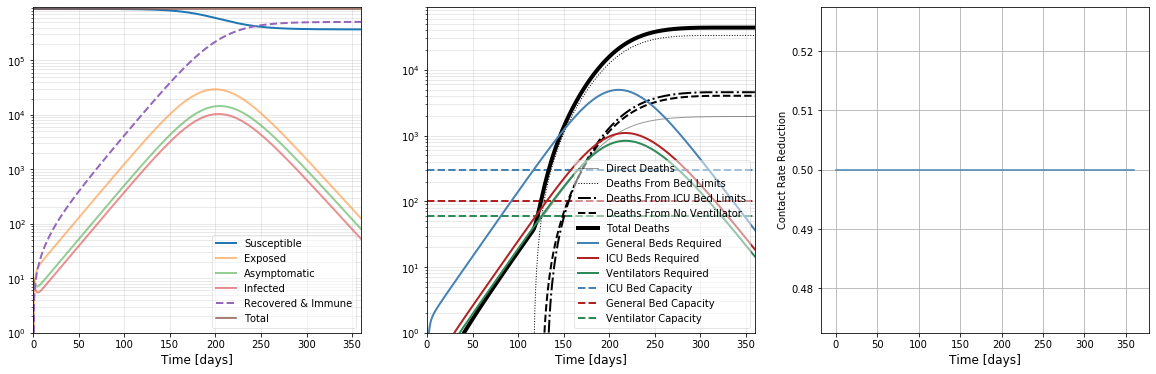

In [336]:
suppression_policy = generate_triggered_suppression_model(t_list=t_list, lockdown_days=100, open_days=0, reduction=0.5)
model = SEIRModel(
    N=age_group_size.sum(),
    A_initial=10,
    I_initial=10, 
    t_list=t_list,
    R0=R0,
    hospitalization_rate_general=(hospitalization_rate_general*age_group_size).sum() / age_group_size.sum(),
    hospitalization_rate_icu=(hospitalization_rate_icu*age_group_size).sum() / age_group_size.sum(),
    mortality_rate=(mortality_rate*age_group_size).sum() / age_group_size.sum(),
    suppression_policy=suppression_policy)

model.run()
model.plot_results()

#### When there is age structure

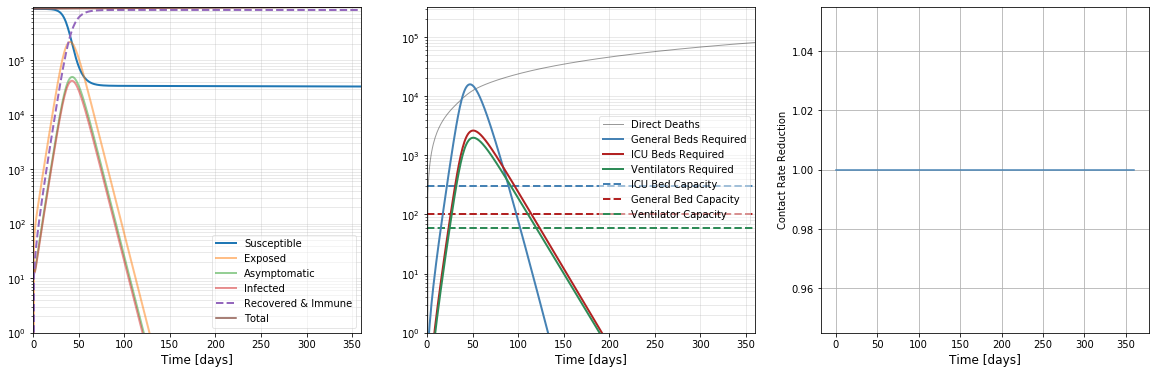

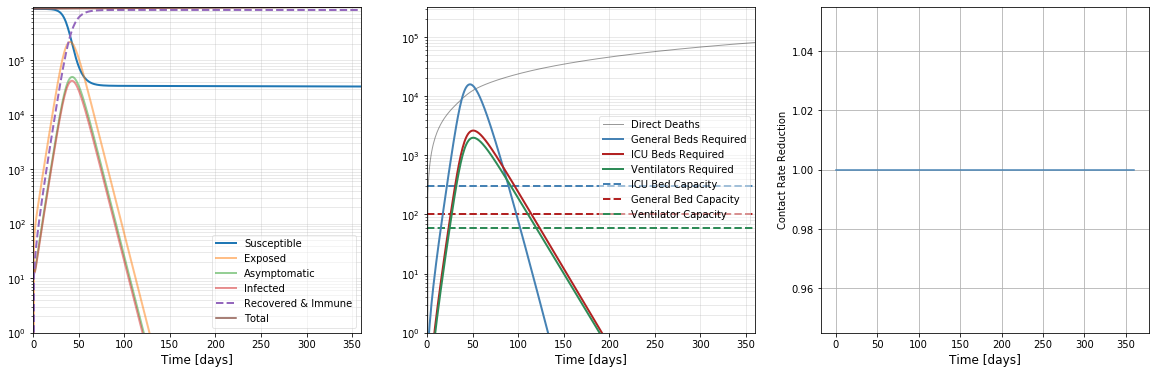

In [337]:
suppression_policy = generate_triggered_suppression_model(t_list=t_list, lockdown_days=0, open_days=0, reduction=1)
model = SEIRModelAge(
    N=age_group_size,
    A_initial=np.zeros(age_group_size.shape[0]) + 1,
    I_initial=np.zeros(age_group_size.shape[0]) + 1,   # only one 
    R_initial=np.zeros(age_group_size.shape[0]),
    E_initial=np.zeros(age_group_size.shape[0]),
    HGen_initial=np.zeros(age_group_size.shape[0]),
    HICU_initial=np.zeros(age_group_size.shape[0]),
    HICUVent_initial=np.zeros(age_group_size.shape[0]),
    contact_matrix=contact_matrix,
    D_initial=0,
    birth_rate=0,
    age_bin_edges=age_bin_edges,
    t_list=t_list,
    R0=R0,
    hospitalization_rate_general=hospitalization_rate_general,
    hospitalization_rate_icu=hospitalization_rate_icu,
    mortality_rate=mortality_rate,
    suppression_policy=suppression_policy)

model.run()
model.plot_results()

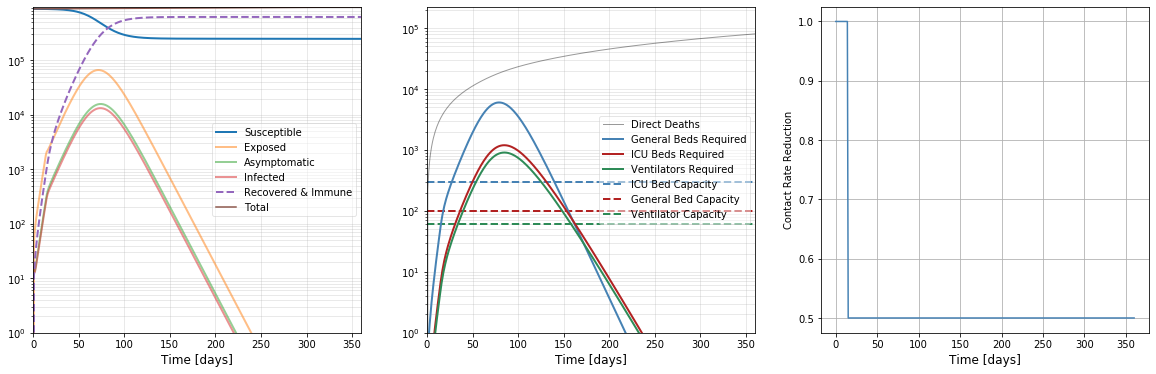

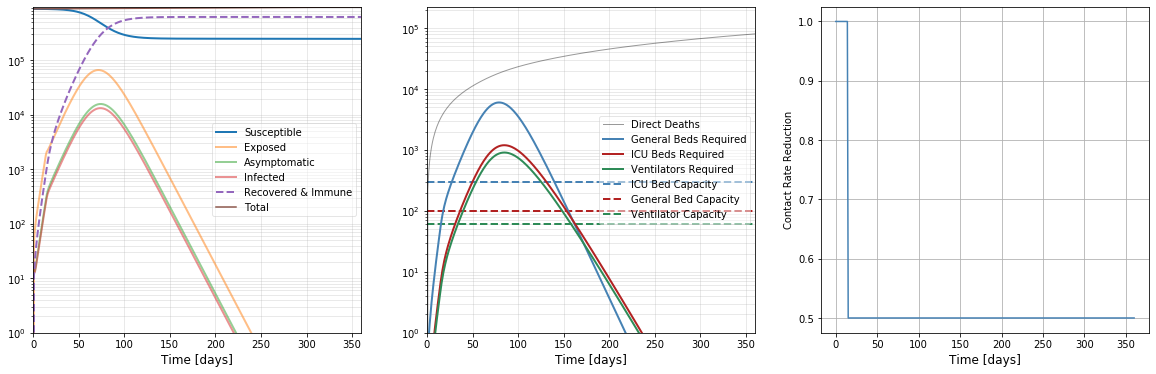

In [338]:
suppression_policy = generate_triggered_suppression_model(t_list=t_list, lockdown_days=100, open_days=0, reduction=0.5, start_on=15)
model = SEIRModelAge(
    N=age_group_size,
    A_initial=np.zeros(age_group_size.shape[0]) + 1,
    I_initial=np.zeros(age_group_size.shape[0]) + 1,   # only one 
    R_initial=np.zeros(age_group_size.shape[0]),
    E_initial=np.zeros(age_group_size.shape[0]),
    HGen_initial=np.zeros(age_group_size.shape[0]),
    HICU_initial=np.zeros(age_group_size.shape[0]),
    HICUVent_initial=np.zeros(age_group_size.shape[0]),
    contact_matrix=contact_matrix,
    D_initial=0,
    birth_rate=0,
    age_bin_edges=age_bin_edges,
    t_list=t_list,
    R0=R0,
    hospitalization_rate_general=hospitalization_rate_general,
    hospitalization_rate_icu=hospitalization_rate_icu,
    mortality_rate=mortality_rate,
    suppression_policy=suppression_policy)

model.run()
model.plot_results()

#### Test of R0
Infection curve should gose down when R0 < 1

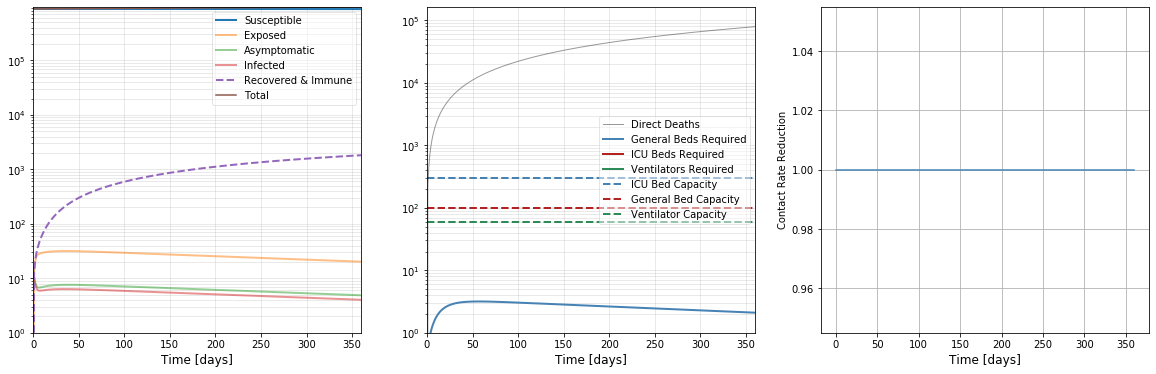

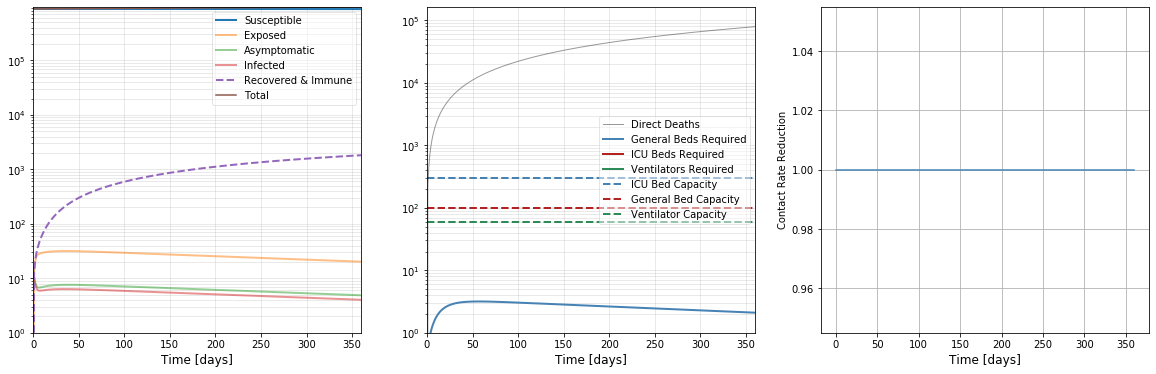

In [339]:
suppression_policy = generate_triggered_suppression_model(t_list=t_list, lockdown_days=0, open_days=0, reduction=1)
model = SEIRModelAge(
    N=age_group_size,
    A_initial=np.zeros(age_group_size.shape[0]) + 1,
    I_initial=np.zeros(age_group_size.shape[0]) + 1,   # only one 
    R_initial=np.zeros(age_group_size.shape[0]),
    E_initial=np.zeros(age_group_size.shape[0]),
    HGen_initial=np.zeros(age_group_size.shape[0]),
    HICU_initial=np.zeros(age_group_size.shape[0]),
    HICUVent_initial=np.zeros(age_group_size.shape[0]),
    contact_matrix=contact_matrix,
    D_initial=0,
    birth_rate=0,
    age_bin_edges=age_bin_edges,
    t_list=t_list,
    R0=0.99,
    hospitalization_rate_general=hospitalization_rate_general,
    hospitalization_rate_icu=hospitalization_rate_icu,
    mortality_rate=mortality_rate,
    suppression_policy=suppression_policy)

model.run()
model.plot_results()